<a href="https://colab.research.google.com/github/gimhaninavodya/ResNet_Deep_Learning/blob/main/aptos_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [1]:
# Install libraries
# opencv-python-headless avoids some Colab conflicts
!pip install -q timm albumentations opencv-python-headless pandas scikit-learn matplotlib seaborn tqdm wandb

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set the paths

In [3]:
DATA_DIR = '/content/drive/MyDrive/aptos'
IMG_DIR = f'{DATA_DIR}/train_images'
CSV_PATH = f'{DATA_DIR}/train.csv'

import os
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("IMG_DIR exists:", os.path.exists(IMG_DIR))
print("CSV exists:", os.path.exists(CSV_PATH))
if os.path.exists(DATA_DIR):
    print("Folder contents:", os.listdir(DATA_DIR)[:20])

DATA_DIR exists: True
IMG_DIR exists: True
CSV exists: True
Folder contents: ['sample_submission.csv', 'test.csv', 'train.csv', 'test_images', 'train_images']


# Quick EDA (see labels and sample images)

Total images: 3662
Class counts:
 diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64
Detected extension: .png


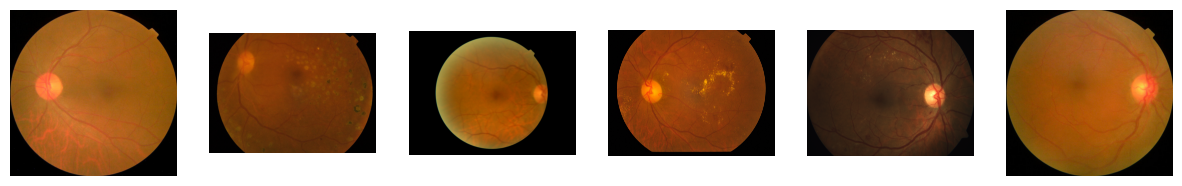

In [4]:
# EDA: class counts and sample images
import pandas as pd, cv2, matplotlib.pyplot as plt, numpy as np, random, os, glob

df = pd.read_csv(CSV_PATH)
print("Total images:", len(df))
print("Class counts:\n", df['diagnosis'].value_counts())

# detect extension
def detect_ext(img_dir, sample_id):
    files = glob.glob(os.path.join(img_dir, sample_id + ".*"))
    return os.path.splitext(files[0])[1] if files else ".png"

ext = detect_ext(IMG_DIR, df['id_code'].iloc[0])
print("Detected extension:", ext)

# Show random sample images
def show_samples(n=6, seed=42):
    random.seed(seed)
    ids = random.sample(list(df['id_code']), n)
    plt.figure(figsize=(15,4))
    for i, idc in enumerate(ids):
        p = os.path.join(IMG_DIR, idc + ext)
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img); plt.axis("off")
    plt.show()

show_samples(6)

# Crop helper & CLAHE

In [5]:
def crop_border_rgb(img, tol=7):
    # img: RGB uint8, tol: threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if mask.any():
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        return img[y0:y1, x0:x1]
    return img

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

visually check that cropping & clahe

In [6]:
import os, cv2, matplotlib.pyplot as plt

sample_id = df['id_code'].iloc[0]   # first image from CSV
ext = detect_ext(IMG_DIR, sample_id)
img_path = os.path.join(IMG_DIR, sample_id + ext)

# load image (RGB)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
print("Original shape:", img.shape)

# crop black borders and apply CLAHE after crop
# same crop, but brighter contrast and fine blood vessels and details are clearer.
cropped = crop_border_rgb(img)
clahe_img = apply_clahe(cropped)
print("After crop shape:", cropped.shape)

Original shape: (2136, 3216, 3)
After crop shape: (2136, 2709, 3)


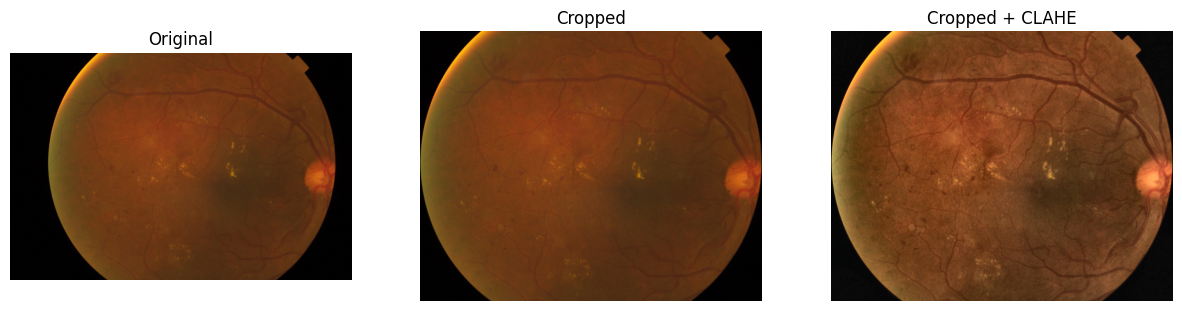

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cropped)
plt.title("Cropped")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(clahe_img)
plt.title("Cropped + CLAHE")
plt.axis("off")

plt.show()

# Transforms & Dataset

In [23]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

IMG_MEAN = (0.485, 0.456, 0.406)
IMG_STD  = (0.229, 0.224, 0.225)

def get_transforms(img_size=224, is_train=True, use_mixup=False):
    if is_train:
        aug = [
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT),
            A.RandomResizedCrop(size=(img_size, img_size), scale=(0.8,1.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.RandomRotate90(p=0.3),
            A.ColorJitter(0.2,0.2,0.2,0.02, p=0.5),
            A.OneOf([A.GaussNoise(), A.ISONoise()], p=0.2),
            A.Affine(translate_percent=0.05, scale=(0.9,1.1), rotate=(-15,15), p=0.4),
            A.Normalize(mean=IMG_MEAN, std=IMG_STD),
            ToTensorV2(),
        ]
        return A.Compose(aug)
    else:
        return A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT),
            A.Resize(height=img_size, width=img_size),
            A.Normalize(mean=IMG_MEAN, std=IMG_STD),
            ToTensorV2(),
        ])

class APTOSDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None, ext=".png", crop_border=False, clahe=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.ext = ext
        self.crop_border = crop_border
        self.clahe = clahe

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + self.ext)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        if self.crop_border: img = crop_border_rgb(img)
        if self.clahe: img = apply_clahe(img)
        if self.transforms: img = self.transforms(image=img)['image']
        return img, int(row['diagnosis'])

# Loaders (with stratified split)


In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def make_loaders(data_dir=DATA_DIR, img_size=224, batch_size=32, ext=None, crop=False, clahe=False):
    df = pd.read_csv(os.path.join(data_dir, "train.csv"))

    # detect extension
    if ext is None:
        ext = detect_ext(os.path.join(data_dir,"train_images"), df['id_code'].iloc[0])

    # stratified split
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

    train_ds = APTOSDataset(train_df, os.path.join(data_dir,"train_images"), transforms=get_transforms(img_size, is_train=True), ext=ext, crop_border=crop, clahe=clahe)
    val_ds   = APTOSDataset(val_df, os.path.join(data_dir,"train_images"), transforms=get_transforms(img_size, is_train=False), ext=ext, crop_border=crop, clahe=clahe)

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
        train_df, val_df
    )

# Quick check
train_loader, val_loader, train_df, val_df = make_loaders(img_size=224, batch_size=16)
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape)

Batch shape: torch.Size([16, 3, 224, 224])


visualize one batch from the loader

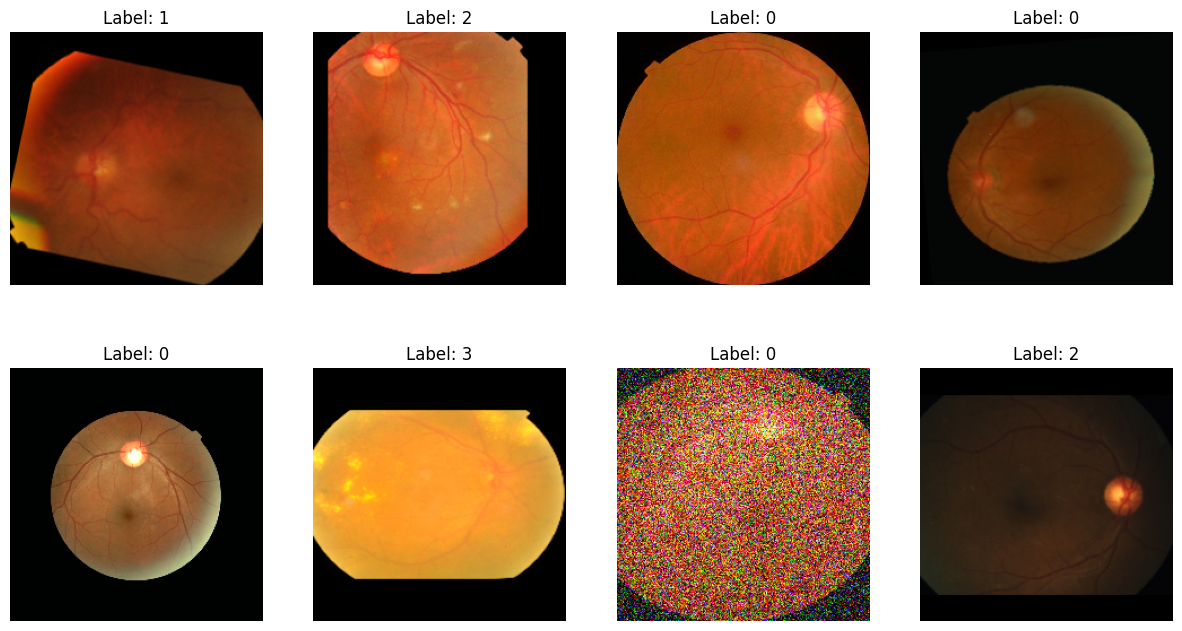

In [25]:
imgs, labels = next(iter(train_loader))

plt.figure(figsize=(15,8))
for i in range(8):  # show first 8 images
    img = imgs[i].permute(1,2,0).cpu().numpy()
    img = (img * IMG_STD + IMG_MEAN).clip(0,1)  # unnormalize
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()